In [1]:
import pickle


data_path = '/Users/yanghongchen/workspace/MYGO/tags/subgraph.pkl'
with open(data_path, 'rb') as f:
    data = pickle.load(f)

In [2]:
# edge_index (LongTensor, optional) – Graph connectivity in COO format with shape [2, num_edges]. (default: None)
# build edge_index from data['src'], data['dst']
edge_index = []
for src, dst in zip(data['src'], data['dst']):
    edge_index.append([src, dst])

In [4]:
import torch

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

In [5]:
edge_index

tensor([[3635, 3635, 2532,  ...,  839, 1837, 2399],
        [ 701,  701, 2278,  ...,  984,   28,  984]])

In [6]:
edge_attr = torch.tensor(data['feature'], dtype=torch.float)

In [7]:
edge_attr

tensor([[0.9962, 0.0078, 0.0031,  ..., 0.0000, 0.0013, 1.0000],
        [0.9962, 0.0026, 0.0000,  ..., 0.0000, 0.0013, 1.0000],
        [0.9962, 0.0052, 0.0031,  ..., 0.0000, 0.0013, 1.0000],
        ...,
        [0.9965, 0.0753, 0.0230,  ..., 0.0000, 0.8289, 1.0000],
        [0.9965, 0.0753, 0.0230,  ..., 0.0000, 0.9483, 1.0000],
        [0.9965, 0.0753, 0.0230,  ..., 0.0000, 0.5230, 1.0000]])

In [8]:
# y (torch.Tensor, optional) – Graph-level or node-level ground-truth labels with arbitrary shape. (default: None)
y = torch.tensor(data['label'], dtype=torch.float)

In [9]:
y

tensor([0., 0., 0.,  ..., 1., 1., 1.])

In [10]:
time = torch.tensor(data['timestamp'], dtype=torch.float)

In [11]:
time

tensor([   57.,    57.,    57.,  ..., 35809., 40964., 22592.])

In [13]:
from torch_geometric.data import Data

data = Data( edge_index=edge_index, edge_attr=edge_attr, y=y, time=time)

In [20]:
data

Data(edge_index=[2, 22287], edge_attr=[22287, 76], y=[22287], time=[22287])

In [21]:
# save data
torch.save(data, 'data.pt')

In [19]:
import torch
from torch_geometric.nn import GCNConv

data
# Data(edge_index=[2, 22287], edge_attr=[22287, 76], y=[22287], time=[22287])

import torch.nn.functional as F

# Extract number of features from the data
edge_feature_dim = edge_attr.size(1)

# Create node features if not present (using random embeddings)
if not hasattr(data, 'x'):
    num_nodes = edge_index.max().item() + 1
    in_channels = 16  # Using the defined in_channels variable
    # Initialize node features
    x = torch.randn(num_nodes, in_channels)
    data.x = x

# Define the GNN model for edge classification
class EdgeClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(EdgeClassifier, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        
        # Edge classifier MLP
        # Concatenate source, destination node features, and edge features
        edge_input_dim = hidden_channels * 2 + edge_feature_dim
        self.edge_mlp = torch.nn.Sequential(
            torch.nn.Linear(edge_input_dim, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_channels, 1)
        )
    
    def forward(self, x, edge_index, edge_attr):
        # Node embeddings
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        
        # Extract source and destination node features for each edge
        src, dst = edge_index
        edge_src_features = x[src]
        edge_dst_features = x[dst]
        
        # Concatenate source, destination features, and edge features
        edge_features = torch.cat([edge_src_features, edge_dst_features, edge_attr], dim=1)
        
        # Predict edge scores
        edge_scores = self.edge_mlp(edge_features)
        return torch.sigmoid(edge_scores)


hidden_channels = 64  # Define hidden channels for the GNN layers
# Initialize model
model = EdgeClassifier(in_channels=in_channels, hidden_channels=hidden_channels)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Define loss function
criterion = torch.nn.BCELoss()

# Print model summary
print(model)


# Training loop
epochs = 100
# Split data into train/val/test sets (8:1:1 split)
num_edges = edge_index.size(1)
indices = torch.randperm(num_edges)
train_size = int(0.8 * num_edges)
val_size = int(0.1 * num_edges)
test_size = num_edges - train_size - val_size

train_idx = indices[:train_size]
val_idx = indices[train_size:train_size+val_size]
test_idx = indices[train_size+val_size:]

# Training loop
print(f"Training on {len(train_idx)} edges, validating on {len(val_idx)} edges, testing on {len(test_idx)} edges")
best_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass - using x variable instead of data.x
    out = model(x, edge_index, edge_attr)
    out = out.squeeze()
    
    # Calculate loss on training edges
    train_loss = criterion(out[train_idx], y[train_idx])
    
    # Backward pass
    train_loss.backward()
    optimizer.step()
    
    # Evaluation on validation set
    model.eval()
    with torch.no_grad():
        # Validation metrics
        val_out = model(x, edge_index, edge_attr).squeeze()
        val_loss = criterion(val_out[val_idx], y[val_idx])
        
        # Test metrics
        test_out = model(x, edge_index, edge_attr).squeeze()
        test_loss = criterion(test_out[test_idx], y[test_idx])
        
        # Calculate accuracy
        train_pred = (out[train_idx] > 0.5).float()
        train_acc = (train_pred == y[train_idx]).sum().item() / len(train_idx)
        
        val_pred = (val_out[val_idx] > 0.5).float()
        val_acc = (val_pred == y[val_idx]).sum().item() / len(val_idx)
        
        test_pred = (test_out[test_idx] > 0.5).float()
        test_acc = (test_pred == y[test_idx]).sum().item() / len(test_idx)
    
    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f'Epoch: {epoch+1:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}, '
              f'Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')
    
    # Save best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_edge_classifier.pt')

# Load best model for final evaluation
model.load_state_dict(torch.load('best_edge_classifier.pt'))
model.eval()
with torch.no_grad():
    final_out = model(x, edge_index, edge_attr).squeeze()
    final_pred = (final_out > 0.5).float()
    final_acc = (final_pred == y).sum().item() / len(y)
    print(f"Final accuracy: {final_acc:.4f}")
    
    # Final metrics per split
    final_train_acc = (final_pred[train_idx] == y[train_idx]).sum().item() / len(train_idx)
    final_val_acc = (final_pred[val_idx] == y[val_idx]).sum().item() / len(val_idx)
    final_test_acc = (final_pred[test_idx] == y[test_idx]).sum().item() / len(test_idx)
    
    print(f"Final train accuracy: {final_train_acc:.4f}")
    print(f"Final validation accuracy: {final_val_acc:.4f}")
    print(f"Final test accuracy: {final_test_acc:.4f}")

EdgeClassifier(
  (conv1): GCNConv(16, 64)
  (conv2): GCNConv(64, 64)
  (edge_mlp): Sequential(
    (0): Linear(in_features=204, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)
Training on 17829 edges, validating on 2228 edges, testing on 2230 edges
Epoch: 010, Train Loss: 0.4715, Val Loss: 0.4713, Test Loss: 0.4613, Train Acc: 0.6613, Val Acc: 0.8483, Test Acc: 0.8493
Epoch: 020, Train Loss: 0.2300, Val Loss: 0.2889, Test Loss: 0.2810, Train Acc: 0.8495, Val Acc: 0.8456, Test Acc: 0.8475
Epoch: 030, Train Loss: 0.1384, Val Loss: 0.1415, Test Loss: 0.1357, Train Acc: 0.9988, Val Acc: 0.9753, Test Acc: 0.9843
Epoch: 040, Train Loss: 0.0955, Val Loss: 0.1470, Test Loss: 0.1435, Train Acc: 0.9993, Val Acc: 0.9982, Test Acc: 0.9996
Epoch: 050, Train Loss: 0.0519, Val Loss: 0.0902, Test Loss: 0.0862, Train Acc: 0.9997, Val Acc: 0.9991, Test Acc: 0.9996
Epoch: 060, Train Loss: 0.0229, Val Loss: 0.0279, Test Loss: 0.0244, Train Acc:

/var/folders/5c/tg8psmpx7f59dj3f7h296hbw0000gn/T/ipykernel_62508/739297440.py:134: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_edge_

/Users/yanghongchen/miniforge3/envs/g/lib/python3.12/site-packages/gudhi/persistence_graphical_tools.py:290: SyntaxWarning: invalid escape sequence '\l'
  :param band: band (not displayed if :math:`\leq` 0. - default is 0.)


Input PyG Data:
Data(edge_index=[2, 498], edge_attr=[498, 76], y=[498], time=[498])
Number of nodes (inferred): 100

Building Filtration...
Filtration built. Simplex tree has 578 simplices.

Computing Persistence...
Computed Persistence. Found 100 H0 features, 379 H1 features.


/Users/yanghongchen/miniforge3/envs/g/lib/python3.12/site-packages/persim/landscapes/visuals.py:310: SyntaxWarning: invalid escape sequence '\l'
  ax.plot(ls[:, 0], ls[:, 1], label=f"$\lambda_{{{depth}}}$", alpha=alpha)
/Users/yanghongchen/miniforge3/envs/g/lib/python3.12/site-packages/persim/landscapes/visuals.py:469: SyntaxWarning: invalid escape sequence '\l'
  ax.plot(domain, l, label=f"$\lambda_{{{depth}}}$", alpha=alpha)
/Users/yanghongchen/miniforge3/envs/g/lib/python3.12/site-packages/torch_geometric/data/storage.py:452: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index', 'y', 'edge_attr', 'time'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


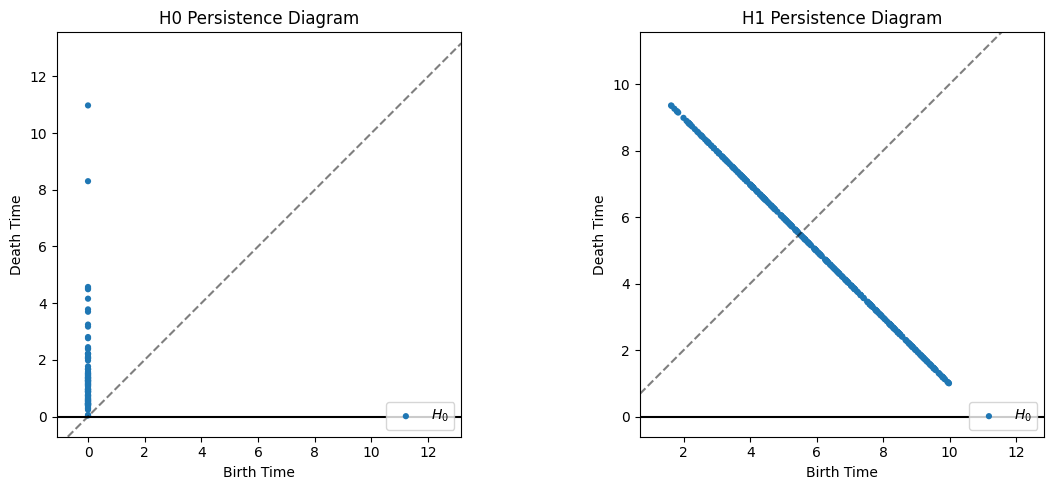

/var/folders/5c/tg8psmpx7f59dj3f7h296hbw0000gn/T/ipykernel_62508/3977799653.py:126: DeprecationWarning: Call to deprecated class PersImage. (Replaced with the class `persim.PersistenceImager`.) -- Deprecated since version 0.1.5.
  pimg = persim.PersImage(pixels=pixels, spread=spread)



Generating Persistent Image(s)...
PersImage(pixels=[50, 50], spread=0.5, specs=None, kernel_type="gaussian", weighting_type="linear")
Generated H0 Persistent Image with shape: (50, 50)
Generated H1 Persistent Image with shape: (50, 50)


AttributeError: 'PersImage' object has no attribute 'show_image'

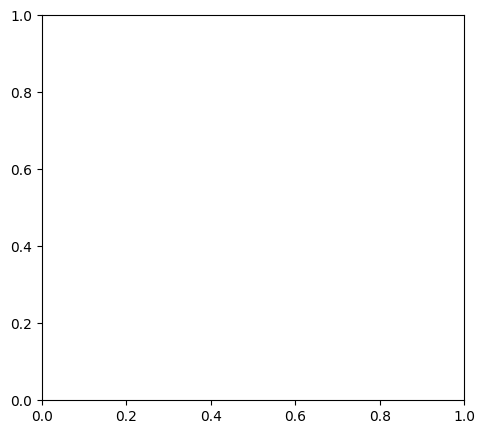

In [23]:
import torch
import numpy as np
from torch_geometric.data import Data
import gudhi
import persim
import matplotlib.pyplot as plt

# --- 1. Sample Data (Mimicking your structure) ---
# Replace this with your actual data loading
num_nodes = 100
num_edges = 500

# Ensure edge_index values are within [0, num_nodes-1]
edge_index = torch.randint(0, num_nodes, (2, num_edges), dtype=torch.long)

# Make sure there are no self-loops for simplicity in this example filtration
edge_index = edge_index[:, edge_index[0] != edge_index[1]]
num_edges = edge_index.shape[1] # Update num_edges after removing self-loops

# Create dummy edge attributes and labels (not used for PI calculation here)
edge_attr = torch.rand(num_edges, 76)
y = torch.rand(num_edges) # Or torch.randint(0, num_classes, (num_edges,))

# Crucial part: Assign a 'time' value to each edge for the filtration
# Simulating edges appearing over time
time = torch.rand(num_edges) * 10 # Example times between 0 and 10

# Create the PyG Data object
data = Data(edge_index=edge_index, edge_attr=edge_attr, y=y, time=time)
print("Input PyG Data:")
print(data)
print(f"Number of nodes (inferred): {data.num_nodes}") # PyG infers this

# --- 2. Build Filtration using Gudhi ---
print("\nBuilding Filtration...")

# Create an empty simplex tree (Gudhi's data structure for complexes)
st = gudhi.SimplexTree()

# Add all nodes (0-simplices) with filtration value 0 (they exist from the start)
for i in range(data.num_nodes):
    st.insert([i], filtration=0.0)

# Sort edges based on their time attribute
edge_indices_np = data.edge_index.numpy().T # Shape: [num_edges, 2]
times_np = data.time.numpy()               # Shape: [num_edges]

# Combine indices and times, then sort by time
sorted_edges = sorted(zip(edge_indices_np, times_np), key=lambda x: x[1])

# Add edges (1-simplices) to the simplex tree according to their time
# Gudhi automatically handles higher-order simplices (like triangles)
# The filtration value of a simplex is the maximum of its faces.
for (u, v), t in sorted_edges:
    # Ensure u and v are standard Python ints if needed by Gudhi version
    u_int, v_int = int(u), int(v)
    st.insert([u_int, v_int], filtration=float(t))
    # print(f"Added edge ({u_int}, {v_int}) at time {t}") # Uncomment for debugging

print(f"Filtration built. Simplex tree has {st.num_simplices()} simplices.")

# --- 3. Compute Persistent Homology ---
print("\nComputing Persistence...")
# Compute persistence pairs. persistence_dim_max=True computes for all dimensions possible.
# Use min_persistence to filter out noise if needed (e.g., min_persistence=0.1)
persistence_pairs = st.persistence(persistence_dim_max=True)

# Gudhi returns a list of (dimension, (birth, death)) tuples.
# Separate diagrams by dimension (H0: components, H1: cycles/loops)
diag_h0 = st.persistence_intervals_in_dimension(0)
diag_h1 = st.persistence_intervals_in_dimension(1)
# diag_h2 = st.persistence_intervals_in_dimension(2) # If you expect 2D voids

# Handle infinite persistence (often happens for H0, the main connected component)
# Replace infinity with a reasonable upper bound based on your max filtration time
max_filt_val = times_np.max() if len(times_np) > 0 else 1.0
# A common practice is to set death = max_filtration_value + small_delta
# Or, Persim can sometimes handle np.inf directly depending on the operation
upper_bound = max_filt_val * 1.1

diag_h0_finite = np.where(np.isinf(diag_h0), upper_bound, diag_h0)
diag_h1_finite = np.where(np.isinf(diag_h1), upper_bound, diag_h1)

print(f"Computed Persistence. Found {len(diag_h0)} H0 features, {len(diag_h1)} H1 features.")
# print("H0 Diagram (finite):\n", diag_h0_finite)
# print("H1 Diagram (finite):\n", diag_h1_finite)


# --- Optional: Visualize Persistence Diagrams ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
persim.plot_diagrams(diag_h0_finite, show=False, title="H0 Persistence Diagram", lifetime=True) # lifetime highlights persistence
plt.axline([0,0], slope=1, color='k', linestyle='--', alpha=0.5) # Add y=x line
plt.xlabel("Birth Time")
plt.ylabel("Death Time")

plt.subplot(1, 2, 2)
if len(diag_h1_finite) > 0:
    persim.plot_diagrams(diag_h1_finite, show=False, title="H1 Persistence Diagram", lifetime=True)
    plt.axline([0,0], slope=1, color='k', linestyle='--', alpha=0.5) # Add y=x line
    plt.xlabel("Birth Time")
    plt.ylabel("Death Time")
else:
    plt.title("H1 Persistence Diagram (Empty)")
    plt.xlim(0, upper_bound) # Set limits appropriately
    plt.ylim(0, upper_bound)
    plt.axline([0,0], slope=1, color='k', linestyle='--', alpha=0.5)
    plt.xlabel("Birth Time")
    plt.ylabel("Death Time")

plt.tight_layout()
plt.show()


# --- 4. Generate Persistent Image ---
print("\nGenerating Persistent Image(s)...")

# Define PI parameters
pixels = [50, 50] # Resolution of the image (adjust as needed)
spread = 0.5      # Gaussian kernel standard deviation (adjust as needed)

# Create a Persistent Image generator object
# You can customize weighting functions, kernel, etc.
# Default weight is linear ramp based on persistence (death-birth)
pimg = persim.PersImage(pixels=pixels, spread=spread)

# Generate PI for H0 and H1 separately
# Note: H0 often contains many points near the diagonal (low persistence)
# and one point with high persistence (the main component).
# PI might be more informative for H1 (cycles) in many graph contexts.

img_h0 = None
if len(diag_h0_finite) > 0:
    # `pimg.transform` expects a list of diagrams, even if there's only one.
    img_h0 = pimg.transform([diag_h0_finite])[0]
    print(f"Generated H0 Persistent Image with shape: {img_h0.shape}")
else:
    print("H0 diagram is empty, cannot generate H0 Persistent Image.")
    img_h0 = np.zeros(pixels) # Create an empty image

img_h1 = None
if len(diag_h1_finite) > 0:
    img_h1 = pimg.transform([diag_h1_finite])[0]
    print(f"Generated H1 Persistent Image with shape: {img_h1.shape}")
else:
    print("H1 diagram is empty, cannot generate H1 Persistent Image.")
    img_h1 = np.zeros(pixels) # Create an empty image


# --- Optional: Visualize Persistent Images ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
pimg.show_image(img_h0, title="H0 Persistent Image")


plt.subplot(1, 2, 2)
pimg.show_image(img_h1, title="H1 Persistent Image")

plt.tight_layout()
plt.show()

# --- Result ---
# img_h0 and img_h1 are your persistent images (NumPy arrays)
# You can flatten them (img_h0.flatten()) to use as feature vectors in ML models.
print("\nPersistent Images generated successfully.")

In [85]:
import torch
import numpy as np
from gudhi import SimplexTree
from persim import PersistenceImager

def ph_emb(edge_index, filtration, pixel_size=0.1, birth_range=(0, 1), pers_range=(0, 1), retain_inf=True, draw_image = False, batch_norm = False):
    """
    Compute the persistent homology feature (persistence image) for a graph.

    Args:
        edge_index (torch.Tensor): Tensor of shape [2, num_edges] representing the graph's edges.
        filtration (torch.Tensor): Tensor of shape [num_edges] with filtration values for each edge.
        pixel_size (float, optional): Size of pixels in the persistence image. Defaults to 0.1.
        birth_range (tuple, optional): Range of birth values for the persistence image. Defaults to (0, 1).
        pers_range (tuple, optional): Range of persistence values for the persistence image. Defaults to (0, 1).
        retain_inf (bool, optional): Whether to replace infinite death times with 1.0. Defaults to True.

    Returns:
        torch.Tensor: Flattened persistence image representing the PH feature of the graph.
    """
    
    # Ensure filtration is not empty
    if filtration.numel() == 0:
        return torch.zeros(int((1 / pixel_size) ** 2), dtype=torch.float32)

        # Ensure filtration has valid values
    if filtration.min() == filtration.max():
        filtration = torch.full_like(filtration, 0.5)

    # Min-max scale the filtration to 0-1
    min_filtration = filtration.min()
    max_filtration = filtration.max()
    filtration = (filtration - min_filtration) / (max_filtration - min_filtration)
    # Identify unique nodes and create a mapping to consecutive integers
    nodes = torch.unique(edge_index)
    node_map = {node.item(): i for i, node in enumerate(nodes)}

    # Remap edge_index to use consecutive node indices
    src = torch.tensor([node_map[edge_index[0, i].item()] for i in range(edge_index.size(1))], dtype=torch.long)
    dst = torch.tensor([node_map[edge_index[1, i].item()] for i in range(edge_index.size(1))], dtype=torch.long)
    remapped_edge_index = torch.stack([src, dst], dim=0)

    # Build the simplex tree
    simplices = SimplexTree()
    for edge, f in zip(remapped_edge_index.T, filtration):
        u, v = edge[0].item(), edge[1].item()
        simplices.insert([u, v], f.item())

    # Compute persistence diagram
    diagrams = simplices.persistence(persistence_dim_max=True)

    # Process persistence pairs
    if retain_inf:
        diagrams = [
            (birth, death if not np.isinf(death) else 1.0)
            for dim, (birth, death) in diagrams
        ]
    else:
        diagrams = [
            (birth, death) for dim, (birth, death) in diagrams if not np.isinf(death)
        ]

    # Handle empty diagrams
    if not diagrams:
        embedding_dim = int((1 / pixel_size) ** 2)  # Assumes birth_range and pers_range are (0, 1)
        return torch.zeros(embedding_dim, dtype=torch.float32)

    # Compute persistence image
    pimgr = PersistenceImager(
        pixel_size=pixel_size,
        birth_range=birth_range,
        pers_range=pers_range
    )
    # visualize the ph image
    
    img = pimgr.transform(diagrams)
    if batch_norm:
        # eg: [[0.1, 0.2], [0.3, 0.4]] -> [[0, 0.33], [0.67, 1]]
        # img = (img - img.min()) / (img.max() - img.min())
        delta = img.max() - img.min()
        if delta == 0:
            img = torch.zeros_like(img)
        else:
            img = (img - img.min()) / delta
    for i in img:
        print(i)
    if draw_image:
        pimgr.plot_image(img)
    img = img.flatten()

    return torch.tensor(img, dtype=torch.float32)

[1.         0.9995504  0.98028696 0.94278115 0.88813425 0.81792364
 0.73412718 0.63903077 0.53512506 0.42499787]
[0.99401362 0.99355075 0.97433372 0.93693263 0.88244567 0.81244556
 0.72890419 0.63410044 0.53051721 0.42073417]
[0.96935534 0.96888392 0.94990319 0.9129762  0.85918722 0.79008881
 0.70762742 0.61405237 0.51181432 0.40345931]
[0.92675465 0.92627966 0.90771809 0.87162057 0.81904699 0.75151481
 0.6709263  0.57947965 0.47956968 0.37368435]
[0.86745638 0.86698288 0.84901109 0.81407415 0.76319786 0.69785065
 0.61987322 0.53139247 0.43472545 0.33227927]
[0.79316026 0.79269325 0.77546494 0.7419864  0.69324061 0.63063448
 0.55593146 0.47116907 0.37856691 0.28043077]
[0.70594004 0.7054843  0.68913237 0.65736932 0.61112775 0.55174226
 0.48088556 0.40049019 0.31266133 0.2195858 ]
[0.6081475  0.60770744 0.5923411  0.56250431 0.51907309 0.46330093
 0.3967587  0.32126124 0.23878538 0.15138458]
[0.50230748 0.50188704 0.48758997 0.45984039 0.41945304 0.36759353
 0.3057225  0.23552732 0.1588

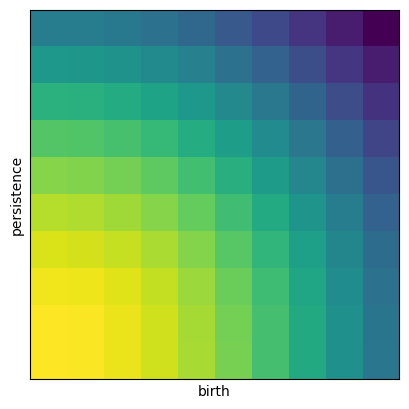

In [88]:
x = ph_emb(data.edge_index, data.time, retain_inf=False, pixel_size = 0.1, draw_image = True, batch_norm= True)

In [89]:
x

tensor([1.0000, 0.9996, 0.9803, 0.9428, 0.8881, 0.8179, 0.7341, 0.6390, 0.5351,
        0.4250, 0.9940, 0.9936, 0.9743, 0.9369, 0.8824, 0.8124, 0.7289, 0.6341,
        0.5305, 0.4207, 0.9694, 0.9689, 0.9499, 0.9130, 0.8592, 0.7901, 0.7076,
        0.6141, 0.5118, 0.4035, 0.9268, 0.9263, 0.9077, 0.8716, 0.8190, 0.7515,
        0.6709, 0.5795, 0.4796, 0.3737, 0.8675, 0.8670, 0.8490, 0.8141, 0.7632,
        0.6979, 0.6199, 0.5314, 0.4347, 0.3323, 0.7932, 0.7927, 0.7755, 0.7420,
        0.6932, 0.6306, 0.5559, 0.4712, 0.3786, 0.2804, 0.7059, 0.7055, 0.6891,
        0.6574, 0.6111, 0.5517, 0.4809, 0.4005, 0.3127, 0.2196, 0.6081, 0.6077,
        0.5923, 0.5625, 0.5191, 0.4633, 0.3968, 0.3213, 0.2388, 0.1514, 0.5023,
        0.5019, 0.4876, 0.4598, 0.4195, 0.3676, 0.3057, 0.2355, 0.1588, 0.0776,
        0.3910, 0.3906, 0.3774, 0.3519, 0.3147, 0.2670, 0.2100, 0.1454, 0.0748,
        0.0000])

In [ ]:
import torch
import numpy as np
import gudhi
from persim import PersistenceImager # Only needed for optional PH analysis of subgraph
from torch_geometric.data import Data
from torch_geometric.utils import k_hop_subgraph, to_networkx
import networkx as nx # For visualization/debug if needed
from collections import defaultdict
import math
import random

# --- PH Computation Helper (Adapted from provided code) ---
def compute_ph_features(edge_index, filtration, persistence_threshold=0.1, target_dim_h1=1, target_dim_h0=0):
    """
    Computes persistent homology and extracts important features.

    Args:
        edge_index (torch.Tensor): Shape [2, num_edges].
        filtration (torch.Tensor): Shape [num_edges], ALREADY NORMALIZED to [0, 1].
        persistence_threshold (float): Minimum persistence to consider a feature important.
        target_dim_h1 (int): Dimension for H1 features (cycles).
        target_dim_h0 (int): Dimension for H0 features (connected components).

    Returns:
        tuple: (
            list: List of important features [{'dim', 'birth', 'death', 'persistence'}],
            dict: Mapping from original node index to Gudhi index,
            SimplexTree: The Gudhi simplex tree object (optional, for debug)
        )
    """
    if edge_index.numel() == 0 or filtration.numel() == 0:
        print("Warning: Empty graph or filtration provided to compute_ph_features.")
        return [], {}, gudhi.SimplexTree()
    if filtration.min() < 0.0 or filtration.max() > 1.0 + 1e-6: # Allow small tolerance
         raise ValueError("Filtration must be normalized to [0, 1] before calling compute_ph_features.")
    if edge_index.max() >= 100000: # Gudhi performance warning for very large node indices direct mapping
         print("Warning: Large node indices detected. Consider remapping if performance is slow.")

    st = gudhi.SimplexTree()
    num_nodes = int(edge_index.max().item() + 1)
    unique_nodes = torch.unique(edge_index)
    node_map = {node_id.item(): i for i, node_id in enumerate(unique_nodes)}
    # Add isolated nodes if any exist up to num_nodes
    # for i in range(num_nodes):
    #    if i not in node_map:
    #       node_map[i] = len(node_map) # Gudhi might not need explicit isolated node insertion if only edges are used? Check gudhi docs.
    # Gudhi typically infers vertices from the edges inserted.

    print(f"Building SimplexTree with {len(node_map)} nodes and {edge_index.size(1)} edges...")
    # Insert edges with filtration values
    for i in range(edge_index.size(1)):
        u, v = edge_index[0, i].item(), edge_index[1, i].item()
        f = filtration[i].item()
        # Map nodes to Gudhi's 0-based consecutive indices
        if u in node_map and v in node_map:
            u_mapped, v_mapped = node_map[u], node_map[v]
            st.insert([u_mapped, v_mapped], filtration=f)
        else:
             print(f"Warning: Edge ({u}, {v}) involves nodes not in unique_nodes derived from edge_index. Skipping.")


    print("Computing persistence...")
    st.persistence()
    print("Persistence computation done.")

    important_features = []
    # Get persistence pairs for H0 and H1
    pairs_h0 = st.persistence_intervals_in_dimension(target_dim_h0)
    pairs_h1 = st.persistence_intervals_in_dimension(target_dim_h1)

    all_pairs = [(target_dim_h0, pair) for pair in pairs_h0] + \
                [(target_dim_h1, pair) for pair in pairs_h1]

    max_filtration_val = filtration.max().item() # Should be close to 1.0

    for dim, (birth, death) in all_pairs:
         # Handle infinite death times - replace with max filtration value (normalized to 1.0)
        if np.isinf(death):
            death = max_filtration_val # Use actual max, should be ~1.0

        persistence = death - birth
        if persistence >= persistence_threshold:
            important_features.append({
                'dim': dim,
                'birth': birth,
                'death': death,
                'persistence': persistence
            })

    print(f"Found {len(important_features)} important features (persistence >= {persistence_threshold}).")
    return important_features, node_map, st


# --- Gaussian Weight Helper ---
def gaussian_weight(x, mu, sigma):
    """Calculates Gaussian weight."""
    if sigma == 0: return 1.0 if x == mu else 0.0
    return math.exp(-(x - mu)**2 / (2 * sigma**2))

# --- Main Sampling Algorithm ---
def ph_guided_random_walk_sampler(data: Data,
                                filtration_key: str = 'time',
                                persistence_threshold: float = 0.1,
                                target_dim_h1: int = 1,
                                target_dim_h0: int = 0,
                                sigma_node: float = 0.05,
                                sigma_edge: float = 0.05,
                                weight_h0_node: float = 0.5,
                                weight_h0_edge: float = 0.5,
                                use_persistence_weighting: bool = True,
                                node_importance_bias_factor: float = 1.0,
                                edge_bias_bias_factor: float = 1.0,
                                num_walks_per_node_or_total: int = 1000, # If > num_nodes, treated as total steps/walks
                                walk_length: int = 40,
                                escape_prob: float = 0.15,
                                start_node_sampling_strategy: str = 'weighted_by_importance'):
    """
    Performs PH-Guided Random Walk sampling on a graph.

    Args:
        data (Data): Input graph data object. Must contain edge_index and filtration_key attribute.
        filtration_key (str): Key for the edge filtration values (e.g., 'time').
        ... (other hyperparameters as defined in documentation) ...

    Returns:
        Data: The sampled subgraph Data object.
    """
    print("Starting PH-Guided Random Walk Sampler...")
    edge_index = data.edge_index
    filtration = data[filtration_key]

    if edge_index.numel() == 0:
        print("Input graph has no edges. Returning empty graph.")
        return Data(edge_index=torch.empty((2,0), dtype=torch.long))

    # --- Step 1: Preprocessing & PH Feature Extraction ---
    print("Normalizing filtration...")
    min_f, max_f = filtration.min(), filtration.max()
    if max_f == min_f:
        norm_filtration = torch.zeros_like(filtration) + 0.5 # Handle constant filtration
        print("Warning: Filtration values are constant.")
    else:
        norm_filtration = (filtration - min_f) / (max_f - min_f)

    print("Computing PH features...")
    important_features, node_map_gudhi, _ = compute_ph_features(
        edge_index, norm_filtration, persistence_threshold, target_dim_h1, target_dim_h0
    )
    # Create inverse map: gudhi_idx -> original_node_idx
    inv_node_map_gudhi = {v: k for k, v in node_map_gudhi.items()}


    num_original_nodes = int(data.edge_index.max().item() + 1) # Estimate based on max index
    node_importance = torch.zeros(num_original_nodes, dtype=torch.float32)
    edge_bias = torch.ones(edge_index.size(1), dtype=torch.float32) # Start with base bias 1.0

    print("Calculating node importance and edge bias...")
    # Iterate through edges to calculate importance/bias
    # This part requires associating edges back to the PH features.
    # A simplified approach: Check filtration value against birth/death times.
    for i in range(edge_index.size(1)):
        u, v = edge_index[0, i].item(), edge_index[1, i].item()
        f_norm = norm_filtration[i].item()

        edge_bias_h1 = 0.0
        edge_bias_h0 = 0.0
        node_importance_contrib = 0.0 # Accumulate contribution for this edge

        for feature in important_features:
            persistence_weight = feature['persistence'] if use_persistence_weighting else 1.0
            if feature['dim'] == target_dim_h1:
                # H1 contribution (cycles) - check birth time
                weight_node = gaussian_weight(f_norm, feature['birth'], sigma_node) * persistence_weight
                weight_edge = gaussian_weight(f_norm, feature['birth'], sigma_edge) * persistence_weight
                node_importance_contrib += weight_node
                edge_bias_h1 += weight_edge
            elif feature['dim'] == target_dim_h0:
                # H0 contribution (components) - check death time
                weight_node = gaussian_weight(f_norm, feature['death'], sigma_node) * persistence_weight * weight_h0_node
                weight_edge = gaussian_weight(f_norm, feature['death'], sigma_edge) * persistence_weight * weight_h0_edge
                node_importance_contrib += weight_node
                edge_bias_h0 += weight_edge

        # Assign scores (ensure nodes exist in the graph)
        if u < num_original_nodes:
             node_importance[u] += node_importance_contrib
        if v < num_original_nodes:
             node_importance[v] += node_importance_contrib
        edge_bias[i] = 1.0 + edge_bias_h1 + edge_bias_h0


    print("Building adjacency list...")
    adj = defaultdict(list)
    for i in range(edge_index.size(1)):
        u, v = edge_index[0, i].item(), edge_index[1, i].item()
        adj[u].append({'neighbor': v, 'edge_idx': i})
        adj[v].append({'neighbor': u, 'edge_idx': i}) # Assume undirected

    sampled_nodes = set()
    total_steps_taken = 0

    # Determine total steps vs walks per node
    is_total_steps_mode = num_walks_per_node_or_total > num_original_nodes
    if is_total_steps_mode:
         total_target_steps = num_walks_per_node_or_total
         print(f"Running in total steps mode: {total_target_steps} steps")
    else:
         num_walks_per_node = num_walks_per_node_or_total
         total_target_steps = num_original_nodes * num_walks_per_node * walk_length # Rough upper bound
         print(f"Running in walks per node mode: {num_walks_per_node} walks/node, length {walk_length}")


    # --- Step 2: Execute PH-Guided Random Walk ---
    print("Starting random walks...")
    active_nodes = list(adj.keys()) # Nodes with edges
    if not active_nodes:
         print("No nodes with edges found. Returning empty graph.")
         return Data(edge_index=torch.empty((2,0), dtype=torch.long))

    while total_steps_taken < total_target_steps:
        # --- Select Start Node ---
        start_node = -1
        if start_node_sampling_strategy == 'weighted_by_importance' and node_importance.sum() > 0:
             weights = node_importance[active_nodes] # Get importance for active nodes only
             if weights.sum() > 0:
                  start_node_idx = torch.multinomial(weights / weights.sum(), 1).item()
                  start_node = active_nodes[start_node_idx]
             else: # Fallback if all importance is zero
                  start_node = random.choice(active_nodes)
        else: # Uniform start
             start_node = random.choice(active_nodes)

        if start_node == -1: continue # Should not happen if active_nodes is not empty

        # --- Perform one walk ---
        current_walk = [start_node]
        current_node = start_node
        steps_in_walk = 0

        while steps_in_walk < walk_length:
            print(f"Current walk: {current_walk}, current node: {current_node}, steps in walk: {steps_in_walk}")
            neighbors_info = adj[current_node]
            if not neighbors_info:
                break # Dead end

            # --- Decide next step ---
            next_node = -1
            if random.random() < escape_prob:
                # Uniform escape
                chosen_neighbor_info = random.choice(neighbors_info)
                next_node = chosen_neighbor_info['neighbor']
                print(f"Escaping to neighbor: {next_node}")
            else:
                # PH-Guided step
                weights = []
                neighbor_nodes = []
                for info in neighbors_info:
                    neighbor = info['neighbor']
                    edge_idx = info['edge_idx']
                    # Ensure neighbor index is valid before accessing importance
                    neighbor_importance = node_importance[neighbor].item() if neighbor < num_original_nodes else 0.0

                    w = (node_importance_bias_factor * neighbor_importance *
                         edge_bias_bias_factor * edge_bias[edge_idx].item())
                    weights.append(max(w, 1e-9)) # Add epsilon to avoid all zero weights issue
                    neighbor_nodes.append(neighbor)

                weights_tensor = torch.tensor(weights, dtype=torch.float32)
                sum_weights = weights_tensor.sum()

                if sum_weights == 0: # Fallback
                     chosen_neighbor_info = random.choice(neighbors_info)
                     next_node = chosen_neighbor_info['neighbor']
                else:
                    probabilities = weights_tensor / sum_weights
                    chosen_idx = torch.multinomial(probabilities, 1).item()
                    next_node = neighbor_nodes[chosen_idx]
                print(f"PH-guided step to neighbor: {next_node}")

            if next_node != -1:
                current_walk.append(next_node)
                current_node = next_node
                steps_in_walk += 1
                total_steps_taken += 1
                print(f"Step {steps_in_walk}: moved to {current_node}, total steps taken: {total_steps_taken}")
                if is_total_steps_mode and total_steps_taken >= total_target_steps:
                    break # Exit inner loop if total steps reached
            else: # Should not happen with fallback
                break

        # Add nodes from walk to sampled set
        sampled_nodes.update(current_walk)

        # Check exit condition for walks per node mode
        if not is_total_steps_mode:
             # This logic needs refinement - how to count walks per node fairly?
             # Simplification: just check total steps as a proxy or run fixed loops
             pass # For now, rely on total_steps_taken check


    print(f"Walks finished. Sampled {len(sampled_nodes)} unique nodes.")

    # --- Step 3: Subgraph Construction ---
    if not sampled_nodes:
         print("No nodes were sampled. Returning empty graph.")
         return Data(edge_index=torch.empty((2,0), dtype=torch.long))

    final_sampled_nodes_list = sorted(list(sampled_nodes))
    node_map_subgraph = {node: i for i, node in enumerate(final_sampled_nodes_list)}

    subgraph_edge_list = []
    subgraph_edge_attr_list = []
    subgraph_filtration_list = []
    original_edge_indices = [] # Keep track of original edge index for attributes

    for i in range(data.edge_index.size(1)):
        u, v = data.edge_index[0, i].item(), data.edge_index[1, i].item()
        if u in sampled_nodes and v in sampled_nodes:
            u_new, v_new = node_map_subgraph[u], node_map_subgraph[v]
            subgraph_edge_list.append([u_new, v_new])
            original_edge_indices.append(i)
            # Keep original filtration (non-normalized) for the subgraph edges
            subgraph_filtration_list.append(data[filtration_key][i].item())

    if not subgraph_edge_list:
         print("Sampled nodes induce no edges. Returning graph with nodes only.")
         subgraph_edge_index = torch.empty((2,0), dtype=torch.long)
         subgraph_edge_attr = None
         subgraph_filtration = torch.empty((0,), dtype=data[filtration_key].dtype)
    else:
        subgraph_edge_index = torch.tensor(subgraph_edge_list, dtype=torch.long).t().contiguous()
        subgraph_filtration = torch.tensor(subgraph_filtration_list, dtype=data[filtration_key].dtype)

        # Map edge attributes
        if hasattr(data, 'edge_attr') and data.edge_attr is not None:
            subgraph_edge_attr = data.edge_attr[original_edge_indices]
        else:
            subgraph_edge_attr = None

    # Map node features
    subgraph_data = Data()
    subgraph_data.num_nodes = len(final_sampled_nodes_list)
    node_tensor_indices = torch.tensor(final_sampled_nodes_list, dtype=torch.long)

    for key, value in data:
        if key in ['edge_index', 'edge_attr', filtration_key]: # Handled above
            continue
        if torch.is_tensor(value) and value.size(0) == data.num_nodes:
             # Node feature
            setattr(subgraph_data, key, value[node_tensor_indices])
        elif torch.is_tensor(value) and value.size(0) == data.edge_index.size(1):
             # Other edge feature (besides attr and filtration) - needs mapping
             pass # Requires original_edge_indices mapping if needed
        else: # Graph level attributes
             setattr(subgraph_data, key, value)


    subgraph_data.edge_index = subgraph_edge_index
    subgraph_data.edge_attr = subgraph_edge_attr
    setattr(subgraph_data, filtration_key, subgraph_filtration) # Add filtration back

    print(f"Subgraph construction complete. Nodes: {subgraph_data.num_nodes}, Edges: {subgraph_data.edge_index.size(1)}")

    return subgraph_data


# --- Demo Usage ---
if __name__ == '__main__':
    
    data = torch.load('data.pt')
    # At this point, edge_index should have shape [2, N] where N >= 0
    
    edge_index = data.edge_index

    # Check dimensions robustly before accessing size(1)
    if edge_index.ndim == 2:
        num_total_edges = edge_index.size(1)
    elif edge_index.ndim == 1 and edge_index.nelement() == 0: # Should not happen with checks above, but safe fallback
        print("Warning: edge_index became an empty 1D tensor unexpectedly. Recovering.")
        num_total_edges = 0
        edge_index = torch.empty((2, 0), dtype=torch.long) # Ensure correct shape
    else:
        raise RuntimeError(f"Unexpected shape for edge_index: {edge_index.shape}")

    print(f"Debug: Final edge_index shape before filtration assignment: {edge_index.shape}")
    print(f"Debug: Calculated num_total_edges = {num_total_edges}")

    # # Assign filtration values
    # if num_total_edges > 0:
    #     # Example: Assign random filtration for demo
    #     filtration = torch.rand(num_total_edges, dtype=torch.float32)
    # else:
    #     # Handle case with no edges
    #     filtration = torch.empty((0,), dtype=torch.float32)
    
    filtration = data.time

    # --- End of Correction Area ---
    # Create Data object
    data = Data(edge_index=edge_index)
    # Assign filtration, ensuring size matches edge_index
    data.time = filtration
    data.num_nodes = num_nodes
    # Assign other attributes, checking consistency if edges/nodes are zero
    data.y = torch.randint(0, 3, (num_nodes,)) if num_nodes > 0 else torch.empty((0,), dtype=torch.long)
    data.edge_attr = torch.randn(num_total_edges, 4) if num_total_edges > 0 else torch.empty((0,4), dtype=torch.float32)


    print("Original Graph (potentially modified by preprocessing):")
    print(data)
    print(f"Number of nodes: {data.num_nodes}")
    print(f"Number of edges: {data.edge_index.size(1)}")

    # --- Run the Sampler ---
    # Add a check to prevent running sampler on an empty graph if desired
    if data.edge_index.size(1) > 0:
        subgraph = ph_guided_random_walk_sampler(
            data,
            filtration_key='time',
            persistence_threshold=0.05, # Lower threshold for smaller graph demo
            sigma_node=0.05,
            sigma_edge=0.05,
            num_walks_per_node_or_total=5000, # Total steps mode
            walk_length=30,
            escape_prob=0.15
        )

        print("\nSampled Subgraph:")
        print(subgraph)
    else:
        print("\nSkipping sampling because the preprocessed graph has no edges.")

    # ... (rest of the optional PH analysis code) ...

    # Optional: Analyze PH of original vs subgraph (requires PersistenceImager etc.)
    # if subgraph.edge_index.numel() > 0:
    #     print("\nComputing PH for subgraph...")
    #     sub_filtration = subgraph.time
    #     sub_min, sub_max = sub_filtration.min(), sub_filtration.max()
    #     if sub_max > sub_min:
    #          sub_norm_filtration = (sub_filtration - sub_min) / (sub_max - sub_min)
    #     else:
    #          sub_norm_filtration = torch.zeros_like(sub_filtration) + 0.5
    #     sub_features, _, _ = compute_ph_features(subgraph.edge_index, sub_norm_filtration)
    #     # Compare sub_features with original important_features using bottleneck distance etc.

/var/folders/5c/tg8psmpx7f59dj3f7h296hbw0000gn/T/ipykernel_62508/2051345397.py:367: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('data.pt')


Debug: Final edge_index shape before filtration assignment: torch.Size([2, 22287])
Debug: Calculated num_total_edges = 22287
Original Graph (potentially modified by preprocessing):
Data(edge_index=[2, 22287], time=[22287], num_nodes=50, y=[50], edge_attr=[22287, 4])
Number of nodes: 50
Number of edges: 22287
Starting PH-Guided Random Walk Sampler...
Normalizing filtration...
Computing PH features...
Building SimplexTree with 12504 nodes and 22287 edges...
Computing persistence...
Persistence computation done.
Found 86 important features (persistence >= 0.05).
Calculating node importance and edge bias...
Building adjacency list...
Running in walks per node mode: 5000 walks/node, length 30
Starting random walks...
Current walk: [28], current node: 28, steps in walk: 0
Current walk: [28, 1610], current node: 1610, steps in walk: 1
Current walk: [28, 1610, 28], current node: 28, steps in walk: 2
Current walk: [28, 1610, 28, 2099], current node: 2099, steps in walk: 3
Current walk: [28, 161

KeyboardInterrupt: 